# Restricted Logistic Regression
In this notebook, we build a logistic regression classifier that utilizes only basic http header metadata to build a binary classifier -- malicious vs background. In particular, we are *discarding* the features that were engineered with domain expertise.

In [1]:
import string
import os
import pickle
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score

In [2]:
train_attack_types = pd.read_csv("datasets/training_attack_types.txt", delimiter=" ", header=None, names= ["attack_type", "attack_category"])

In [3]:
target = "back"
train_attack_types.loc[train_attack_types["attack_type"]==target, "attack_category"].values[0]

'dos'

In [4]:
cols = list(pd.read_csv("datasets/kddcup.names.txt", skiprows=1, header=None)[0].map(lambda x: str(x).split(":")[0]).values)
cols.append("label")


reduced_cols = cols[:9]
reduced_cols.append("label")

reduced_cols

['duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'label']

In [5]:
train = pd.read_csv("datasets/kddcup.data.corrected.txt", header=None, names=cols)

In [6]:
train = train[reduced_cols].copy()

In [7]:
test = pd.read_csv("datasets/corrected.txt", header=None, names=cols)

In [8]:
test = test[reduced_cols].copy()

In [9]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,label
0,0,tcp,http,SF,215,45076,0,0,0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,normal.
4,0,tcp,http,SF,239,486,0,0,0,normal.


In [10]:
test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,label
0,0,udp,private,SF,105,146,0,0,0,normal.
1,0,udp,private,SF,105,146,0,0,0,normal.
2,0,udp,private,SF,105,146,0,0,0,normal.
3,0,udp,private,SF,105,146,0,0,0,snmpgetattack.
4,0,udp,private,SF,105,146,0,0,0,snmpgetattack.


# EDA

## Process the label column
We want to remove the period. Then we want to generate three label columns:

In [11]:
train["label"] = train["label"].map(lambda x: x.split(".")[0])
test["label"] = test["label"].map(lambda x: x.split(".")[0])

### Binary label (normal/malicious)

In [12]:
train["label_binary"] = train["label"].map(lambda x: 0 if x=="normal" else 1)
test["label_binary"] = test["label"].map(lambda x: 0 if x=="normal" else 1)

In [13]:
test["label_binary"].value_counts()

1    250436
0     60593
Name: label_binary, dtype: int64

In [14]:
train["label_binary"].value_counts()

1    3925650
0     972781
Name: label_binary, dtype: int64

In [15]:
X = pd.get_dummies(train, columns=["protocol_type", "service", "flag"], drop_first=True).drop(columns=["label", "label_binary"])

# Restricted Logistic Regression
How well do we do with only the baseline features?

In [16]:
y = train["label_binary"]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9)

In [18]:
X_train.shape

(489843, 87)

In [19]:
y_train.shape

(489843,)

In [20]:
filename = "./models/restricted_logreg.pickle"
if not os.path.exists(filename):
    now = time.time()
    logreg = LogisticRegression(penalty="none", solver="sag", max_iter=10000, verbose=1, n_jobs = -2)
    logreg.fit(X_train, y_train)
    print(f"fitting completed in {time.time() - now}")
    with open(filename, 'wb') as f:
        pickle.dump(logreg, f)
else:
    with open(filename, 'rb') as f:
        logreg = pickle.load(f)

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.


convergence after 4167 epochs took 3026 seconds
fitting completed in 3027.6745743751526


[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed: 50.4min finished


In [21]:
logreg.score(X_train, y_train)

0.9554469493286625

In [22]:
logreg.score(X_test, y_test)

0.9556012038321567

In [23]:
roc_auc_score(y_train, logreg.predict(X_train))

0.8890899613715503

In [24]:
roc_auc_score(y_test, logreg.predict(X_test))

0.8891418563932382

In [25]:
# cross_val_score(logreg, X_train, y_train)

In [26]:
y_actual = test["label"].map(lambda x: 0 if x == "normal" else 1)
y_actual

0         0
1         0
2         0
3         1
4         1
         ..
311024    0
311025    0
311026    0
311027    0
311028    0
Name: label, Length: 311029, dtype: int64

In [27]:
X_big_test = pd.get_dummies(test, columns=["protocol_type", "service", "flag"], drop_first=True).drop(columns=["label", "label_binary"])

In [28]:
X_big_test.columns

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'protocol_type_tcp', 'protocol_type_udp', 'service_X11',
       'service_Z39_50', 'service_auth', 'service_bgp', 'service_courier',
       'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard',
       'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i',
       'service_ecr_i', 'service_efs', 'service_exec', 'service_finger',
       'service_ftp', 'service_ftp_data', 'service_gopher',
       'service_hostnames', 'service_http', 'service_http_443', 'service_icmp',
       'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell',
       'service_ldap', 'service_link', 'service_login', 'service_mtp',
       'service_name', 'service_netbios_dgm', 'service_netbios_ns',
       'service_netbios_ssn', 'service_netstat', 'service_nnsp',
       'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump',
       'service_pop_2', 'service_pop_3', 'service

In [29]:
X_test.columns

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'protocol_type_tcp', 'protocol_type_udp', 'service_X11',
       'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp',
       'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime',
       'service_discard', 'service_domain', 'service_domain_u', 'service_echo',
       'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec',
       'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher',
       'service_harvest', 'service_hostnames', 'service_http',
       'service_http_2784', 'service_http_443', 'service_http_8001',
       'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell',
       'service_ldap', 'service_link', 'service_login', 'service_mtp',
       'service_name', 'service_netbios_dgm', 'service_netbios_ns',
       'service_netbios_ssn', 'service_netstat', 'service_nnsp',
       'service_nntp', 'service_ntp_u', 'service_other', '

In [30]:
cols_to_zero = [col for col in X_test.columns if col not in X_big_test.columns]
for col in cols_to_zero:
    X_big_test[col] = 0

In [31]:
logreg.score(X_big_test[X_test.columns], y_actual)

0.926813898382466

In [32]:
roc_auc_score(y_actual, logreg.predict(X_big_test[X_test.columns]))

0.9029848941449183

In [33]:
tn, fp, fn, tp = confusion_matrix(logreg.predict(X_big_test[X_test.columns]), y_actual).ravel()

In [34]:
# Our sensitivity is
(tp) / (tp + fn) 

0.9662353938589701

In [35]:
# Our precision is
(tp) / (tp + fp)

0.9420251082112795

In [36]:
coefs = pd.DataFrame(logreg.coef_, columns=X_test.columns, index=["coef_"]).T

In [37]:
with pd.option_context("max_rows", None):
    display(coefs.sort_values(by="coef_", ascending=False))

,coef_
src_bytes,5.295485e-04
service_ecr_i,1.420671e-05
flag_SF,1.043310e-05
service_private,6.090725e-06
flag_S0,5.557342e-06
protocol_type_tcp,3.977647e-06
flag_REJ,1.027613e-06
flag_RSTR,5.636944e-08
service_eco_i,5.578148e-08
flag_RSTO,2.789269e-08


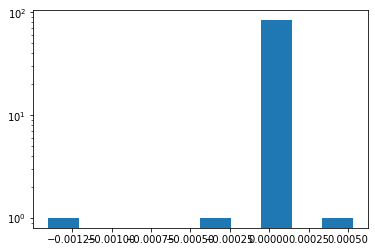

In [38]:
plt.hist(logreg.coef_[0]);
plt.yscale('log')

## Only using basic metadata
It's useful to see how we do with only the first few columns:

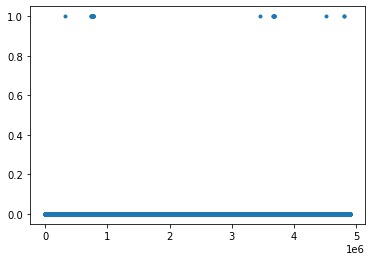

In [39]:
plt.plot(X["land"],'.')

## Residuals
Do an analysis of the resids

Maybe simulate some internal attacks on your own network. Can you connect a networking component with a model scoring component?

Online learning (iterative model updating). See "vawpol wabbit"

See

http://onlineprediction.net/?n=Main.HomePage

https://duckduckgo.com/?q=vawp`ol+wabbit&t=ffab&ia=web
    